[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876106  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167587  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742653  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565186  132079200
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.1609 - val_loss: 0.0246
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0131 - val_loss: 0.0044
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 6/100
18/18 ━━━━━━━━━━━━━

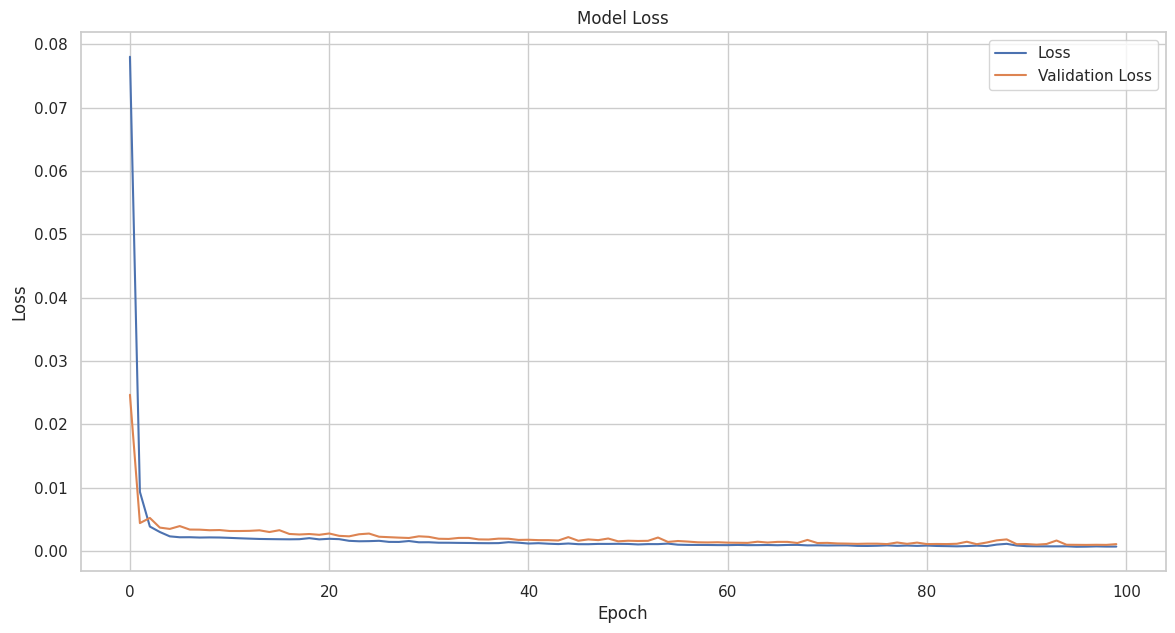

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Mean Squared Error: 14.833296824953932


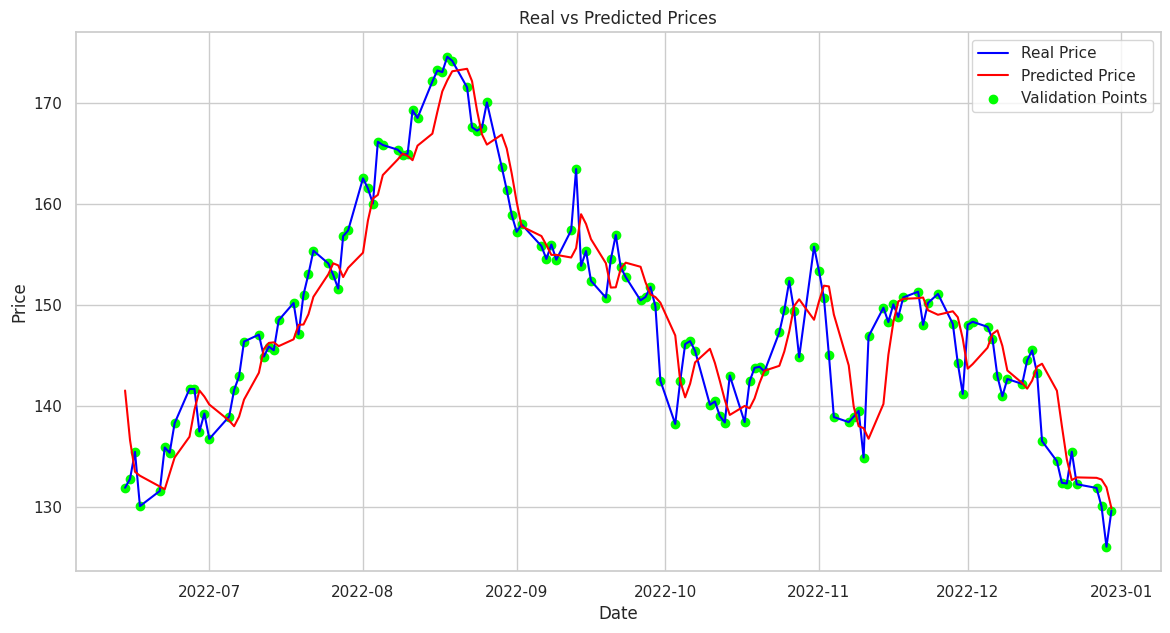

In [22]:
!pip install yfinance pandas numpy scikit-learn keras matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# obter dados históricos de ações
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# definir o ticker e o período de análise
ticker = 'AAPL'  # Apple Inc.
start_date = '2020-01-01'
end_date = '2023-01-01'

# obter dados
data = get_stock_data(ticker, start_date, end_date)

# primeiras linhas dos dados
print(data.head())

# preço de fechamento
data = data[['Close']]

# normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# datasets para treinamento
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# treino e teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape para o formato do LSTM [amostras, timesteps, recursos]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# perda de treinamento
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# previsões
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# calc erro
mse = mean_squared_error(y_test_inv, predictions)
print(f'Mean Squared Error: {mse}')

# plot previsões vs valores reais
plt.figure(figsize=(14, 7))


plot_index = np.arange(len(data.index) - len(y_test_inv), len(data.index))
validation_index = np.arange(len(data.index) - len(y_test_inv), len(data.index))

plt.plot(data.index[-len(y_test_inv):], y_test_inv, color='blue', label='Real Price')
plt.plot(data.index[-len(predictions):], predictions, color='red', label='Predicted Price')

# verde choque
plt.scatter(data.index[-len(y_test_inv):], y_test_inv, color='lime', label='Validation Points', marker='o')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Real vs Predicted Prices')
plt.legend()
plt.show()
